In [268]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import math
import requests
from bs4 import BeautifulSoup
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn import metrics
pd.set_option("display.max_columns",100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [269]:
## Proxy settings when using cntlm
http_proxy  = "http://localhost:3128"
https_proxy = "https://localhost:3128"

proxyDict = { 
              "http"  : http_proxy, 
              "https" : https_proxy, 
            }
proxyDict = None

In [270]:
mapping = {
    'Richmond': 'richmond',
    'West Coast': 'westcoast',
    'Sydney': 'swans',
    'Adelaide': 'adelaide',
    'Geelong': 'geelong',
    'Greater Western Sydney': 'gws',
    'Melbourne': 'melbourne',
    'Port Adelaide': 'padelaide',
    'Collingwood': 'collingwood',
    'Hawthorn': 'hawthorn',
    'Essendon': 'essendon',
    'Western Bulldogs': 'bullldogs',
    'St Kilda': 'stkilda',
    'North Melbourne': 'kangaroos',
    'Kangaroos' : 'kangaroos',
    'Fremantle': 'fremantle',
    'Brisbane Lions': 'brisbanel',
    'Gold Coast': 'goldcoast',
    'Carlton': 'carlton'
}
teams = list(mapping.keys())

In [504]:
from data_prep.team_history import History
# team_df = History(mapping, proxyDict).generate_team_history()
team_df = History(mapping, proxyDict).generate_team_history(season_list=[0]) # current season

Richmond 0
West Coast 0
Sydney 0
Adelaide 0
Geelong 0
Greater Western Sydney 0
Melbourne 0
Port Adelaide 0
Collingwood 0
Hawthorn 0
Essendon 0
Western Bulldogs 0
St Kilda 0
North Melbourne 0
Fremantle 0
Brisbane Lions 0
Gold Coast 0
Carlton 0


In [506]:
from data_prep.team_history import History
# History(mapping, proxyDict).generate_game_data('training-all/', team_df)
History(mapping, proxyDict).generate_game_data('training-all/', team_df, season_list=[0]) # current season

2019 Richmond
2019 West Coast
2019 Sydney
2019 Adelaide
2019 Geelong
2019 Greater Western Sydney
2019 Melbourne
2019 Port Adelaide
2019 Collingwood
2019 Hawthorn
2019 Essendon
2019 Western Bulldogs
2019 St Kilda
2019 North Melbourne
2019 Fremantle
2019 Brisbane Lions
2019 Gold Coast
2019 Carlton


In [507]:
X_list = []
y_list = []

for i in range(0,12):
    X = np.load('training-all/training-'+str(2019-i)+'.npy')

    mask = np.isnan(X).any(axis=1)
    index = np.where(mask==True)[0][0] ## X8 has a row containing nulls
    X = np.delete(X, index, 0)
    X_list.append(X)

    y = np.load('training-all/results-'+str(2019-i)+'.npy')
    y = np.delete(y, index, 0)
    y_list.append(y)
    
X = np.concatenate(X_list, axis=0)
y = np.concatenate(y_list, axis=0)

print(X.shape)
print(y.shape)

print('Wins vs losses',np.sum(y)/float(len(y)))

(2187, 17)
(2187,)
Wins vs losses 0.5697302240512117


In [508]:
from data_prep.feature_eng import Features
cols = Features().cols()
Features().div_cols(X).head()

,Rnd,h_F_mean,h_F_std,h_A_mean,h_A_std,h_M_mean,h_M_std,h_R_mean,h_perc,a_F_mean,a_F_std,a_A_mean,a_A_std,a_M_mean,a_M_std,a_R_mean,a_perc,perc,R_mean,F_mean,A_mean,F_std,A_std
0,2.0,97.000000,0.000000,64.000000,0.000000,33.000000,0.000000,1.000000,1.515625,65.000000,0.000000,72.000000,0.000000,-7.000000,0.000000,0.000000,0.902778,1.678846,0.00,1.492308,0.888889,0.000000,0.000000
1,5.0,84.500000,13.973189,97.750000,22.719760,-13.250000,22.719760,0.500000,0.864450,74.500000,12.257651,86.000000,9.486833,-11.500000,9.486833,0.250000,0.866279,0.997889,2.00,1.134228,1.136628,1.139957,2.394873
2,6.0,85.400000,12.626955,91.600000,23.753737,-6.200000,23.753737,0.600000,0.932314,74.800000,26.194656,103.200000,20.989521,-28.400000,20.989521,0.200000,0.724806,1.286295,3.00,1.141711,0.887597,0.482043,1.131695
3,9.0,84.375000,17.888107,85.625000,25.203856,-1.250000,25.203856,0.625000,0.985401,82.250000,8.757140,78.000000,23.194827,4.250000,23.194827,0.500000,1.054487,0.934484,1.25,1.025836,1.097756,2.042688,1.086615
4,10.0,85.555556,17.192447,82.666667,25.192592,2.888889,25.192592,0.666667,1.034946,79.777778,29.637730,79.111111,19.969112,0.666667,19.969112,0.444444,1.008427,1.026298,1.50,1.072423,1.044944,0.580087,1.261578


In [ ]:
from modelling.training import Training
from scipy.stats import uniform
from scipy.stats import randint
## Using 5 fold cv the average score can be determined by (val. score / 2.8)
## eg if cutoff is 65 then we should expect an average score of 23.2
## If our validation score gets to 70, then we should obtain an average score of 25.

spaceR = {
        'n_estimators': randint(low=350, high=700),
        'max_depth': randint(low=3, high=6),
        'learning_rate': uniform(0.005, 0.1),
        'gamma': uniform(0.04, 0.05),
        'min_child_weight': randint(low=3, high=4),
        'scale_pos_weight': uniform(0, 2),
        'max_delta_step': randint(low=0, high=5),
        'colsample_bytree': uniform(0.1, 0.9),
        'colsample_bylevel': uniform(0.1, 0.9),
        'colsample_bynode': uniform(0.1, 0.9),
        'subsample': uniform(0.1, 0.9),
        'reg_lambda': uniform(0.0, 2.0),
        'reg_alpha': uniform(0.0, 2.0),
        'base_score': uniform(0.5, 0.1),
        }
scores, val_scores, best_models = Training(n_calls=150).trainR(X_list, y_list, space=spaceR)

In [534]:
from skopt.space import Real, Integer

spaceB = {
    'n_estimators': Integer(450, 550),
    'max_depth': Integer(3, 5),
    'learning_rate': Real(0.001, 0.03, "log-uniform"),
    'gamma': Real(0.04, 0.09, "uniform"),
    'min_child_weight': Integer(3, 5),
    'scale_pos_weight': Real(0.9, 1.1, "uniform"),
    'max_delta_step': Integer(3, 5),
    'colsample_bytree': Real(0.1, 1.0, "uniform"),
    'colsample_bylevel': Real(0.1, 1.0, "uniform"),
    'colsample_bynode': Real(0.1, 1.0, "uniform"),
    'subsample': Real(0.05, 0.3, "uniform"),
    'reg_lambda': Real(0.0, 1.5, "uniform"),
    'reg_alpha': Real(0.0, 1.5, "uniform"),
        }
scores, val_scores, best_models = Training(n_calls=50).trainB(X_list, y_list, n_points=3, space=spaceB)

Season 2019
Bayes CV search took 95.76 seconds for 50 candidates parameter settings.
val. score: 59.54935465763599
test score: 3.6441691826008618

Season 2018
Bayes CV search took 92.17 seconds for 50 candidates parameter settings.
val. score: 55.65958185738635
test score: 27.944037005555145

Season 2017
Bayes CV search took 100.06 seconds for 50 candidates parameter settings.
val. score: 58.088781560595564
test score: 13.2907856464436

Season 2016
Bayes CV search took 84.82 seconds for 50 candidates parameter settings.
val. score: 52.471618183896865
test score: 42.71306293890296

Season 2015
Bayes CV search took 94.09 seconds for 50 candidates parameter settings.
val. score: 56.85860877613424
test score: 22.841642689817157

Season 2014
Bayes CV search took 93.79 seconds for 50 candidates parameter settings.
val. score: 57.0867878933083
test score: 19.54031052365691

Season 2013
Bayes CV search took 96.01 seconds for 50 candidates parameter settings.
val. score: 53.74687368360643
test 

In [535]:
scores = scores[1:]
val_scores = val_scores[1:]


Mean test scores 27.293523241012892
Mean validation scores 27.796111490587858


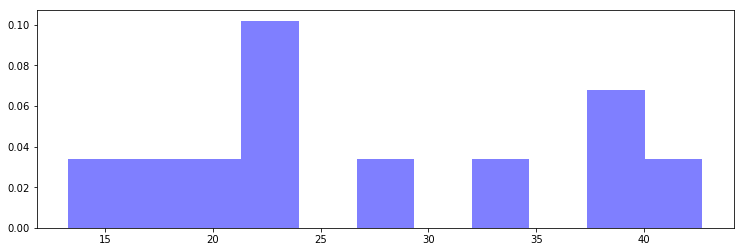

In [537]:
plt.figure(figsize=(12.5,4))
plt.hist(scores, bins=11, density=True, facecolor='blue', alpha=0.5)
print("")
print("Mean test scores", np.mean(scores))
print("Mean validation scores", np.mean(val_scores)/2)

In [536]:
rows = []
for model in best_models:
    rows.append(model.get_params())
pd.DataFrame(rows).describe()

,base_score,colsample_bylevel,colsample_bynode,colsample_bytree,gamma,learning_rate,max_delta_step,max_depth,min_child_weight,n_estimators,n_jobs,random_state,reg_alpha,reg_lambda,scale_pos_weight,subsample
count,12.0,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.0,12.0,12.000000,12.000000,12.000000,12.000000
mean,0.5,0.584363,0.555909,0.700386,0.058187,0.007726,3.916667,4.083333,3.916667,506.666667,-1.0,0.0,0.317260,0.676102,1.015390,0.182873
std,0.0,0.266172,0.284415,0.156317,0.016017,0.003212,0.792961,0.792961,0.792961,37.129585,0.0,0.0,0.461097,0.499898,0.049119,0.077044
min,0.5,0.100000,0.100000,0.454456,0.040000,0.004352,3.000000,3.000000,3.000000,450.000000,-1.0,0.0,0.000000,0.056493,0.930793,0.050000
25%,0.5,0.521871,0.345356,0.619299,0.040908,0.005258,3.000000,3.750000,3.000000,481.000000,-1.0,0.0,0.000000,0.219802,0.986943,0.145475
50%,0.5,0.601607,0.550955,0.695811,0.059160,0.007160,4.000000,4.000000,4.000000,504.500000,-1.0,0.0,0.062314,0.629791,1.012646,0.168951
75%,0.5,0.691445,0.715566,0.794647,0.071721,0.008191,4.250000,5.000000,4.250000,540.250000,-1.0,0.0,0.473108,1.008245,1.038562,0.256513
max,0.5,1.000000,0.986469,1.000000,0.084931,0.015803,5.000000,5.000000,5.000000,550.000000,-1.0,0.0,1.489486,1.474545,1.100000,0.300000


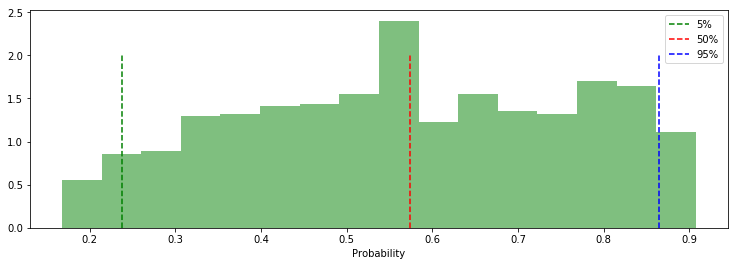

In [538]:
plt.figure(figsize=(12.5,4))
line_height = 2
data = Helpers().averagingModels(np.concatenate(X_list, axis=0), best_models)
_ = plt.hist(data, bins='auto', density=True, facecolor='green', alpha=0.5)

plt.vlines(np.percentile(data, 5), 0, line_height, linestyle="--", colors='green', label="5%")
plt.vlines(np.percentile(data, 50), 0, line_height, linestyle="--", colors='red', label="50%")
plt.vlines(np.percentile(data, 95), 0, line_height, linestyle="--", colors='blue', label="95%")
plt.xlabel('Probability')
plt.legend()

In [539]:
from helper_functions.functions import Helpers

features = Features().div_cols(X_list[0]).columns

imp = pd.DataFrame(data=Helpers().averagingImp(best_models),
             index=features,
             columns=['importance']).sort_values(by=['importance'], ascending=False)
imp

,importance
perc,0.073353
F_mean,0.062320
A_mean,0.060366
h_M_mean,0.053429
R_mean,0.052944
h_perc,0.052147
a_perc,0.048745
a_M_mean,0.046640
h_F_mean,0.044644
h_A_mean,0.042212


## Scoring

In [441]:
from data_prep.web_scraping import Scrape

games = []
start = 134
for i in range(start,start+6):
    games.append(Scrape(mapping, proxyDict).scrape_game(i))
games

/Users/d719674/dev/code/AFL-Monash-comp/data_prep/web_scraping.py:35: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 35 of the file /Users/d719674/dev/code/AFL-Monash-comp/data_prep/web_scraping.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(r.text, "html")


[['Richmond', 'Geelong'],
 ['Carlton', 'Brisbane Lions'],
 ['Gold Coast', 'North Melbourne'],
 ['Adelaide', 'Greater Western Sydney'],
 ['Sydney', 'West Coast'],
 ['Collingwood', 'Melbourne']]

In [453]:
from modelling.scoring import Scoring
scoring = Scoring(mapping, proxyDict).score_data(games).values

In [540]:
def modelStats(X, models=[]):
    predictions = np.column_stack([
        model.predict_proba(X)[:,1] for model in models
    ])
    return [np.mean(predictions, axis=1), np.median(predictions, axis=1), np.std(predictions, axis=1), 
            np.max(predictions, axis=1), np.min(predictions, axis=1)]

arr = np.c_[ games, modelStats(scoring,best_models)[0],
           modelStats(scoring,best_models)[1],modelStats(scoring,best_models)[2],
            modelStats(scoring,best_models)[3], modelStats(scoring,best_models)[4]] 
pd.DataFrame(arr,columns=['home','away', 'prob_avg', 'prob_med', 'prob_std', 'prob_max', 'prob_min'])

,home,away,prob_avg,prob_med,prob_std,prob_max,prob_min
0,Richmond,Geelong,0.40044928,0.39810655,0.020099932,0.44650313,0.3760008
1,Carlton,Brisbane Lions,0.3008254,0.30954808,0.029703764,0.3383016,0.25043416
2,Gold Coast,North Melbourne,0.3560835,0.35862267,0.032708753,0.40232214,0.2762768
3,Adelaide,Greater Western Sydney,0.45917296,0.45664442,0.028989451,0.5267864,0.40316665
4,Sydney,West Coast,0.36387178,0.36707312,0.023024032,0.41046163,0.31767353
5,Collingwood,Melbourne,0.8346141,0.83212256,0.013530873,0.8701214,0.81702673


## Model Analysis

In [541]:
overall = []
for i in range(len(best_models)):
    season_scores = []
    for rnd in range(1,24):
        df = pd.DataFrame(np.c_[X_list[i],y_list[i]])
        y_new = df[df[0] == rnd][17].values
        x_new = df[df[0] == rnd].drop(17, axis=1).values
        score = Helpers().afl_loss(y_new,best_models[i].predict_proba(Features().div_cols(x_new).values)[:,1])
        season_scores.append(score)
    overall.append(season_scores)

Text(0.5, 1.0, 'Average Cumulative Score')

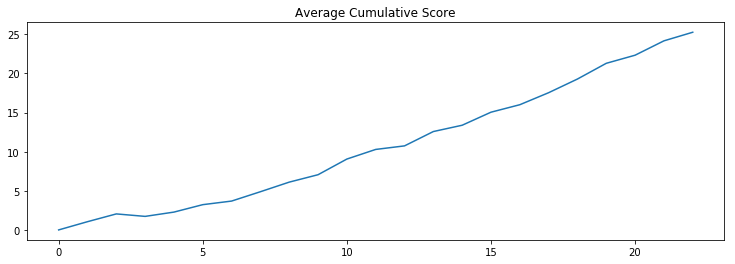

In [542]:
plt.figure(figsize=(12.5,4))
plt.plot(np.cumsum(np.array(np.matrix(np.array(overall)).mean(0)).flatten()))
plt.title('Average Cumulative Score')

In [543]:
data_A = np.load('model_A_scores.npy')
data_B = scores.copy()
print(np.sort(data_A))
print(np.sort(data_B))
print(np.mean(data_A))
print(np.mean(data_B))

[13.62360411 16.69657643 20.8538074  20.95531643 21.32964835 24.48503226
 27.74336028 33.02016146 38.10866212 39.04786432 41.63957179]
[13.29078565 16.97099141 19.54031052 22.71966619 22.84164269 23.52563356
 27.94403701 33.90173401 37.91208691 38.86880478 42.71306294]
27.04578226758966
27.293523241012892


In [544]:
import pymc3 as pm
# The parameters are the bounds of the Uniform.
with pm.Model() as model:
    alpha_A = pm.Exponential('alpha_A', 1/10)
    beta_A = pm.Uniform('beta_A', lower=0, upper=1)
    alpha_B = pm.Exponential('alpha_B', 1/10)
    beta_B = pm.Uniform('beta_B', lower=0, upper=1)
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", alpha_A/beta_A - alpha_B/beta_B)
    
    obs_A = pm.Gamma("obs_A", alpha=alpha_A, beta=beta_A, observed=data_A)
    obs_B = pm.Gamma("obs_B", alpha=alpha_B, beta=beta_B, observed=data_B)
    
    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)
    burned_trace = trace[1000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta_B]
>Metropolis: [alpha_B]
>Metropolis: [beta_A]
>Metropolis: [alpha_A]
Sampling 4 chains: 100%|██████████| 74000/74000 [00:15<00:00, 4823.26draws/s]
The number of effective samples is smaller than 10% for some parameters.


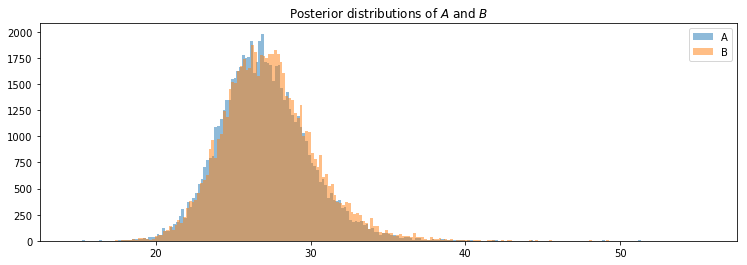

In [545]:
plt.figure(figsize=(12.5,4))
plt.title("Posterior distributions of $A$ and $B$")
plt.hist(burned_trace["alpha_A"]/burned_trace["beta_A"], bins='auto', histtype="stepfilled", alpha=0.5, label="A")
plt.hist(burned_trace["alpha_B"]/burned_trace["beta_B"], bins='auto', histtype="stepfilled", alpha=0.5, label="B")
plt.legend()

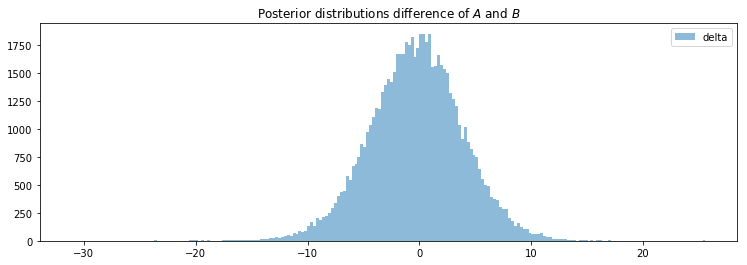

In [546]:
plt.figure(figsize=(12.5,4))
plt.title("Posterior distributions difference of $A$ and $B$")
plt.hist(burned_trace["delta"], bins='auto', histtype="stepfilled", alpha=0.5, label="delta")
plt.legend()

In [547]:
print("Probability model A is WORSE than model B: %.3f" % \
    np.mean(burned_trace["delta"] < 0))

print("Probability model A is BETTER than model B: %.3f" % \
    np.mean(burned_trace["delta"] > 0))

Probability model A is WORSE than model B: 0.522
Probability model A is BETTER than model B: 0.478


In [548]:
np.save('model_A_scores.npy', data_B)

## Save models

In [549]:
from joblib import dump
# dump(model, 'models/model.joblib') 
for i in range(len(best_models)):
    dump(best_models[i], 'models/model'+str(i)+'.joblib') 

## Load models

In [550]:
from joblib import load
# model = load('models2/model.joblib')
best_models = []
for i in range(11):
    best_models.append(load('models/model'+str(i)+'.joblib'))